<a href="https://colab.research.google.com/github/lnpetrova/deeplearning/blob/main/Homework1_Ostyakova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Переводим его в два класса

In [5]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

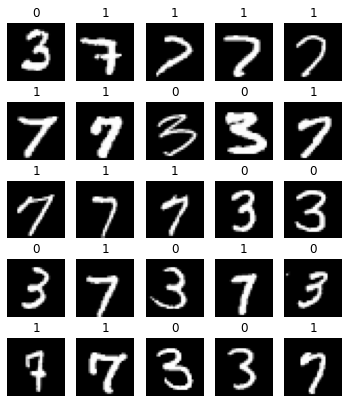

In [7]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [8]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [9]:
x.shape

torch.Size([128, 1, 28, 28])

In [10]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [10]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [11]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [12]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [13]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [14]:
y

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0])

# Итерация по эпохам

In [15]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [16]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.43578198, 0.66693858, 0.15278611, ..., 0.29440661, 0.0674371 ,
        0.91885473],
       [0.28998684, 0.71364435, 0.6950422 , ..., 0.78073245, 0.23271041,
        0.31466062],
       [0.70633694, 0.31320182, 0.76161207, ..., 0.2856754 , 0.97877827,
        0.68683542],
       ...,
       [0.87245644, 0.89562878, 0.82448514, ..., 0.18012179, 0.0900326 ,
        0.67057134],
       [0.17658527, 0.26561009, 0.1738922 , ..., 0.15732038, 0.17704674,
        0.11561056],
       [0.64563277, 0.85506487, 0.05371464, ..., 0.19277739, 0.23178279,
        0.7053384 ]])

In [17]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[-0.64070727,  0.03974975, -1.85537273, ..., -1.1361182 ,
        -2.69201222,  0.75966678],
       [-1.15382737,  0.17191771,  0.11930096, ...,  0.36202041,
        -1.40380635, -1.05724932],
       [ 0.15124897, -1.06281212,  0.30773499, ..., -1.17128863,
         0.93655675,  0.09608231],
       ...,
       [ 0.62473769,  0.69192166,  0.48677958, ..., -1.68167821,
        -2.39947755,  0.05004075],
       [-1.70276903, -1.25517714, -1.71908119, ..., -1.82472121,
        -1.69999599, -2.1441622 ],
       [-0.02068273,  0.57455798, -2.9211845 , ..., -1.60905604,
        -1.40823132,  0.14842467]])

In [18]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [19]:
res

array([[125.77058093, 128.79711632, 132.48426697, ..., 122.18092188,
        126.93581841, 127.87523223],
       [127.4868764 , 133.82044575, 134.30338225, ..., 123.81406933,
        128.9160049 , 132.63484746],
       [133.28857273, 132.49254162, 134.34986163, ..., 126.29802959,
        131.32091014, 133.71470609],
       ...,
       [129.41012203, 135.12227217, 137.45965295, ..., 128.87159934,
        133.47868945, 135.48941443],
       [137.17853975, 141.04234128, 138.27361538, ..., 128.13287332,
        137.65762113, 139.691757  ],
       [133.20418384, 139.24455014, 139.04072076, ..., 127.48049789,
        135.9133249 , 140.99016308]])

In [20]:
res.shape == (x.shape[0], y.shape[1])

True

### Производные линейного слоя
Мы знаем, что нам нужно будет по градиентам весов обновить эти веса. То есть это просто смещение наших весов на какой-то шаг. Отсюда следует, что размерность весов и градиента к ним должна совпадать. Используйте для этого скалярное произведение, траснпонирование и предыдущий градиент.  
То есть размерность какого-либо параметра должна совпадать с размерностью градиента к этому параметру. В случае с параметров b мы помним, что это смещение и по сути это добавление к нашим входным фичам фичи с единичным значением.

```python
grad_w = np.dot(x.T, grad_prev)
grad_x = np.dot(grad_prev, w.T)
grad_b = np.dot(np.ones((x.shape[0])), grad_prev)
```

Более подробный совет:  
Tip: use dimension analysis! Note that you do not need to remember the expressions for dW and dX because they are easy to re-derive based on dimensions. For instance, we know that the gradient on the weights dW must be of the same size as W after it is computed, and that it must depend on matrix multiplication of X and dD (as is the case when both X,W are single numbers and not matrices). There is always exactly one way of achieving this so that the dimensions work out. For example, X is of size [10 x 3] and dD of size [5 x 3], so if we want dW and W has shape [5 x 10], then the only way of achieving this is with np.dot(dD, X.T), as shown above.  
[Источник](https://cs231n.github.io/optimization-2/)

Полезные видео:  
- [Один](https://www.coursera.org/lecture/intro-to-deep-learning/multilayer-perceptron-mlp-yy1NV)
- [Два](https://www.coursera.org/lecture/intro-to-deep-learning/chain-rule-rK0tw)
- [Три](https://www.coursera.org/lecture/intro-to-deep-learning/backpropagation-CxUe5)
- [Четыре](https://www.coursera.org/lecture/intro-to-deep-learning/efficient-mlp-implementation-P3VH6)
- [Пять](https://www.coursera.org/lecture/intro-to-deep-learning/other-matrix-derivatives-YTunl)

# Задание

### Шаги:
1. Задайте обучаемые параметры (TIP: np.random.rand)
1. Задайте скорость обучения (подойдет 0.01, но можете попробовать другие и посмотреть что меняется), количество эпох (полных проходов по датасету)
1. Сделайте линейную трансформацию через первый слой (первый набор весов)
1. Примените какую-нибудь нелийную функцию активации (tanh, relu)
1. Сделайте линейную трансформацию через второй слой (второй набор весов)
1. Примените сигмоиду
1. Рассчитайте функцию потерь (бинарная кросс энтропия), не забудьте усреднить по батчу
1. Сохраняйте значения функции потерь в массив losses
1. Возьмите производные от функции потерь к каждому обучаемому параметру [видео про производные](https://youtu.be/tZ0yCzWfbZc)
1. Обновите веса w1, b1, w2, b2 с помощью градиентного спуска
1. Нарисуйте график функции потерь

- TIP: количество входных фичей - 784 (28 пикселей * 28 пикселей)
- TIP: в шаге 0 домножьте w1, w2 на 0.01, а b1, b2 инициализируйте нулями. Это не самая лучшая реализация, но пока лучше мы не знаем
- TIP: в backward функции потерь по предсказаниям вашей модели нужно разделить еще на количество примеров в батче (не забудьте, что усредняете лосс)
- TIP: каждый следующий градиент рассчитывайте умножая на предыдущий, то есть не нужно расчитывать по каждому слою и затем все мерджить. Нужно сразу для d_L/d_z2 считать градиент как d_L/d_y_hat умноженный на d_y_hat/d_z2, где y_hat это наши предсказания.

## Если вам сложно, сделайте сначала для одного слоя

In [11]:
learning_rate = 0.01
epochs = 10
losses = []
w1 = np.random.rand(784,128) * 0.01
b1 = np.zeros((1,128))
w2 = np.random.rand(128,1)* 0.01
b2 = np.zeros((1,1))


for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        # forward
        z1 = np.dot(x, w1) + b1
        #тангенс
        a1 = (np.exp(z1) - np.exp(-z1)) / (np.exp(z1) + np.exp(-z1))

        z2 = np.dot(a1, w2) + b2
        #сигмоида
        pred = 1/(1 + np.exp(-z2))

        # рассчет bce
        loss_bce = -np.mean((y * np.log(pred) + (1-y) * np.log(1-pred)))
        # не забудьте добавить это значение в массив losses
        losses.append(loss_bce)
        
     # backward

        dL_dpred = ((1-y)/(1-pred) - y/pred) / x.shape[0] 
        dL_dz2 = dL_dpred * pred *(1-pred)  #dL_dpred*dpred_dz2
        dL_da1 = dL_dz2.dot(w2.T)
        dL_dw2 = np.dot(a1.T, dL_dz2)
        dL_db2 = dL_dz2.mean()
        dL_dz1 = dL_da1 * (1 - a1**2)
        dL_dw1 = np.dot(x.T, dL_dz1) 
        dL_db1 = dL_dz1.mean()
              
        # gradient descent
        w1 = w1 - learning_rate * dL_dw1 
        w2 = w2 - learning_rate * dL_dw2
        b1 = b1 - learning_rate * dL_db1
        b2 = b2 - learning_rate * dL_db2

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


In [12]:
np.mean(losses)

0.1310735066167734

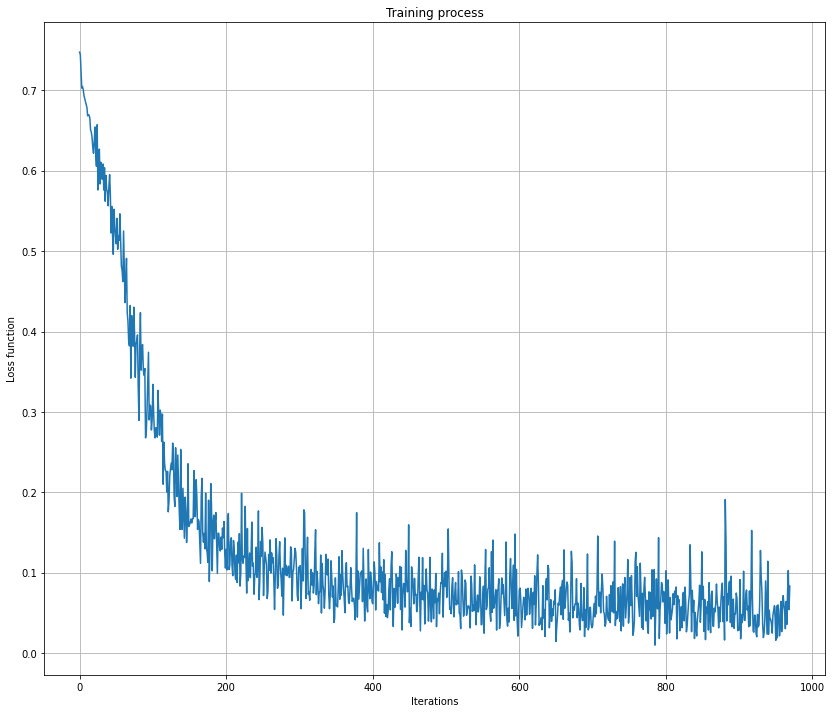

In [13]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred - сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_loss/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_loss/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- d_loss/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- d_loss/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- d_loss/db2 - градиент линейного преобразования по b2 - (1,)
- d_loss/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- d_loss/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- d_loss/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

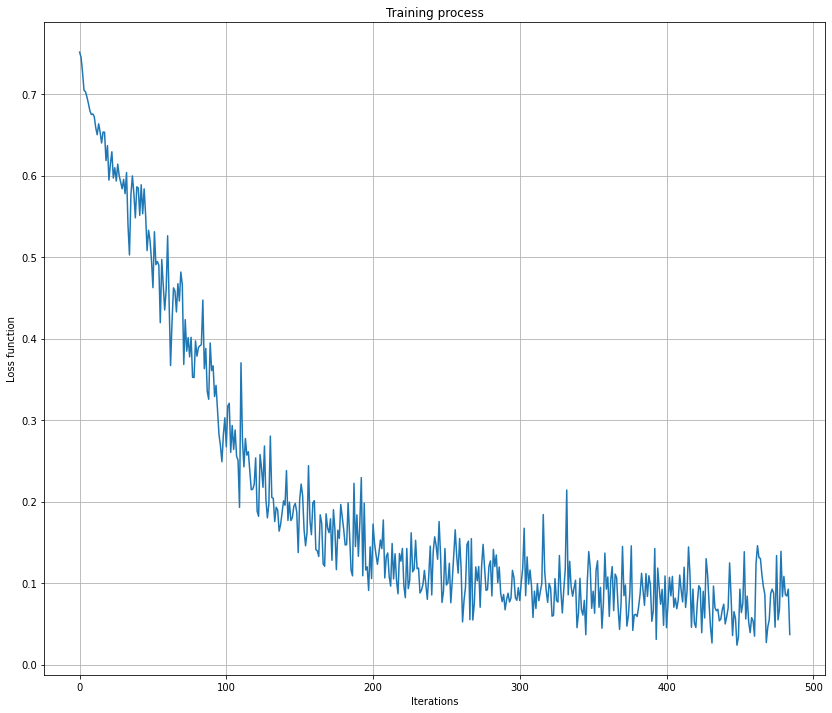

In [26]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Нужно получить значение лосса ниже 0.1 (на графике)
```np.mean(losses)``` примерно должно равняться 0.15  
Это где-то 0.9+ accuracy

# На данном моменте домашка заканчивается
### Если вы хотите сделать более продвинутую версию, то ниже есть все необходимое. В курсе оцениваться никак не будет. Только для большего понимания устройства deep learning фреймворков

# В любом случае стоит посмотреть [введение в torch](#Введение-в-torch)
Вам это понадобится дальше